In [202]:
%load_ext autoreload
%autoreload 2

In [390]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn import metrics
from cw2_utils import load_cw2_data, get_features
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
%matplotlib inline

In [386]:
train_set, test_set, train_labels, test_labels = load_cw2_data()
features = get_features()
print(train_set.shape, test_set.shape)
print(features)

(118, 13) (60, 13)
['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']


(118, 2)
0.866666666667


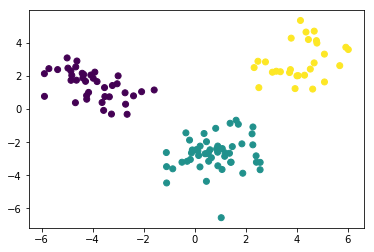

In [387]:
lda = LinearDiscriminantAnalysis()
projected_train = lda.fit_transform(train_set, train_labels)
projected_test = lda.transform(test_set)
print(projected_train.shape)
plt.scatter(projected_train[:, 0], projected_train[:, 1], c = train_labels)

nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(projected_train[:, :2], train_labels)
print(np.mean(nn.predict(projected_test) == test_labels))

In [388]:
print('############## NOT NORMALISED ######################')
km = KMeans(n_clusters=3, n_init = 100, algorithm = 'elkan')
km.fit(train_set)
transformed_train_set = km.transform(train_set)
transformed_test_set = km.transform(test_set)

distance_metrics = ['l1', 'l2', 'cosine', 'chebyshev', 'mahalanobis']
metric_args = [
    ({},{}), ({},{}), ({},{}), ({},{}),
    ({'V': np.cov(transformed_train_set.T)}, {'V': np.cov(train_set.T)})
]
neighbors = 1

for dm, args in zip(distance_metrics, metric_args):

    nn = KNeighborsClassifier(n_neighbors=neighbors, metric=dm, n_jobs = -1, metric_params=args[0])
    nn.fit(transformed_train_set, train_labels)
    print('{} - kmeans + nn: {:.4}'.format(dm, np.mean(nn.predict(transformed_test_set) == test_labels)))

    nn = KNeighborsClassifier(n_neighbors=neighbors, metric=dm, n_jobs = -1, metric_params=args[1])
    nn.fit(train_set, train_labels)
    print('{} - nn: {:.4}\n'.format(dm, np.mean(nn.predict(test_set) == test_labels)))

############## NOT NORMALISED ######################
l1 - kmeans + nn: 0.65
l1 - nn: 0.8

l2 - kmeans + nn: 0.65
l2 - nn: 0.75

cosine - kmeans + nn: 0.65
cosine - nn: 0.8833

chebyshev - kmeans + nn: 0.65
chebyshev - nn: 0.7167

mahalanobis - kmeans + nn: 0.6333
mahalanobis - nn: 0.8833



In [389]:
train_mean = np.mean(train_set, axis = 0)
train_std = np.std(train_set, axis = 0)
train_set = (train_set - train_mean) / train_std
test_set = (test_set - train_mean) / train_std

print('############## NORMALISED ######################')
km = KMeans(n_clusters=3, n_init = 100, algorithm = 'elkan')
km.fit(train_set)
transformed_train_set = km.transform(train_set)
transformed_test_set = km.transform(test_set)

distance_metrics = ['l1', 'l2', 'cosine', 'chebyshev', 'mahalanobis']
metric_args = [
    ({},{}), ({},{}), ({},{}), ({},{}),
    ({'V': np.cov(transformed_train_set.T)}, {'V': np.cov(train_set.T)})
]
neighbors = 1

for dm, args in zip(distance_metrics, metric_args):

    nn = KNeighborsClassifier(n_neighbors=neighbors, metric=dm, n_jobs = -1, metric_params=args[0])
    nn.fit(transformed_train_set, train_labels)
    print('{} - kmeans + nn: {:.4}'.format(dm, np.mean(nn.predict(transformed_test_set) == test_labels)))

    nn = KNeighborsClassifier(n_neighbors=neighbors, metric=dm, n_jobs = -1, metric_params=args[1])
    nn.fit(train_set, train_labels)
    print('{} - nn: {:.4}\n'.format(dm, np.mean(nn.predict(test_set) == test_labels)))

############## NORMALISED ######################
l1 - kmeans + nn: 0.9333
l1 - nn: 0.9167

l2 - kmeans + nn: 0.9167
l2 - nn: 0.9

cosine - kmeans + nn: 0.9167
cosine - nn: 0.9167

chebyshev - kmeans + nn: 0.9167
chebyshev - nn: 0.8833

mahalanobis - kmeans + nn: 0.9
mahalanobis - nn: 0.8833



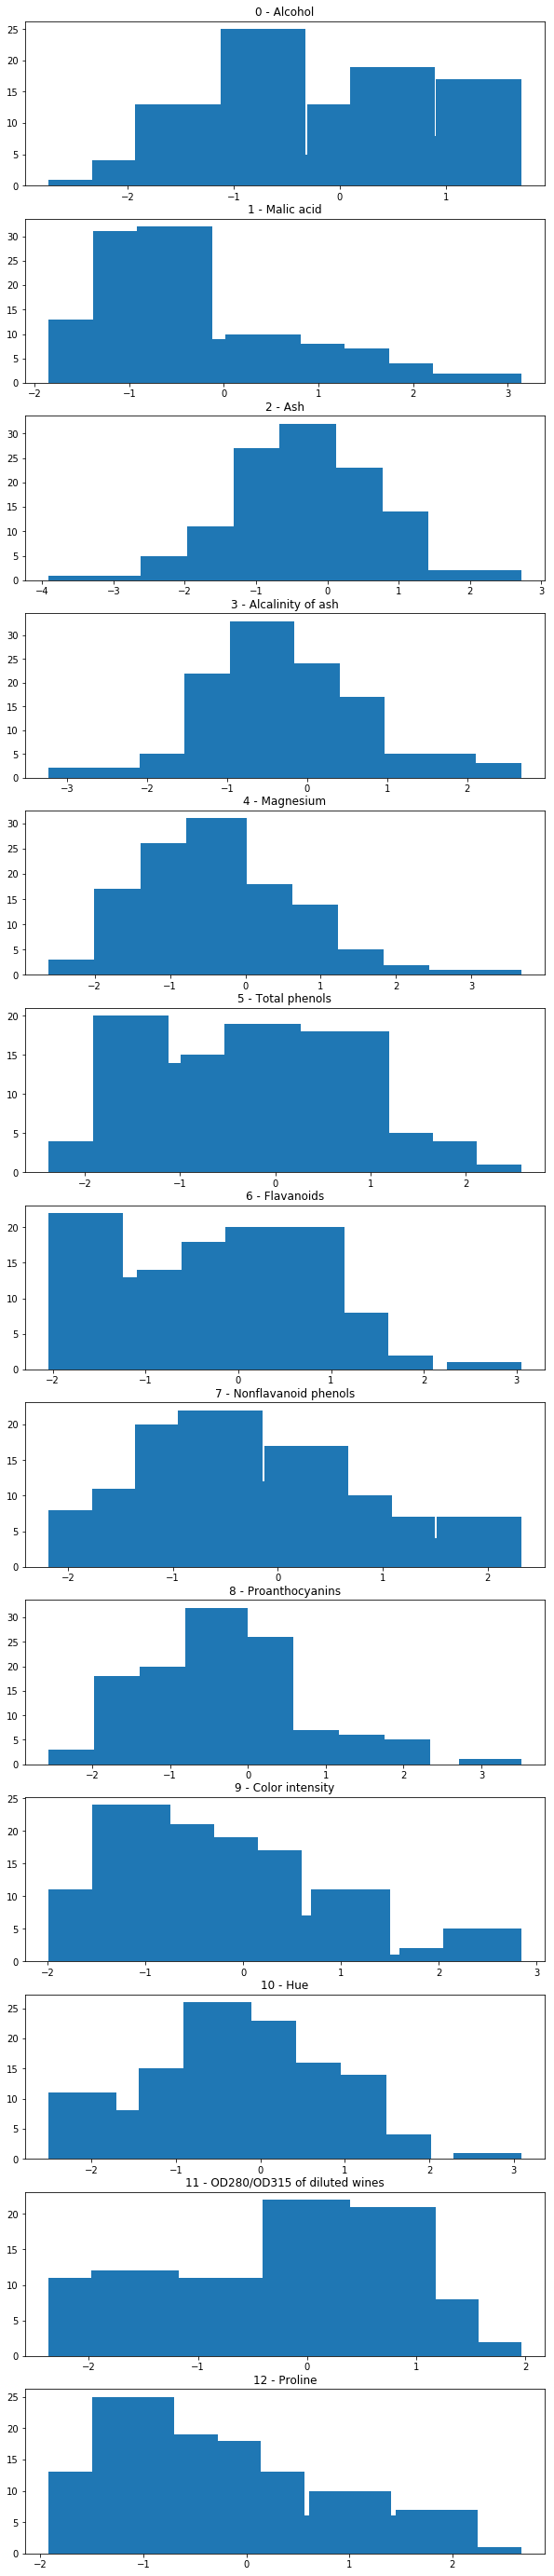

In [379]:
histograms = []
f, axes = plt.subplots(13, 1, figsize = (10, 50))
for feature_id in range(train_set.shape[1]):
    hist, bins = np.histogram(train_set[:, feature_id], bins = int(sqrt(train_set.shape[0])))
    histograms.append((hist, bins))
    axes[feature_id].bar(bins[:-1], hist)
    axes[feature_id].set_title('{} - {}'.format(feature_id, features[feature_id]))

In [301]:
eps = 1e-10

def euclidean(p, q):
    return np.sum((p - q) ** 2, axis = 1)

def l1(p, q):
    return np.sum(np.abs(p - q), axis = 1)

def l2(p, q):
    return np.sqrt(euclidean(p, q))

def linf(p, q):
    return np.max(p - q, axis = 1)

def cosine(p, q):
    return np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))

def KLdiv(p, q):
    return np.sum(p * np.log(p / (q + eps)), axis = 1)

def chi2(p, q):
    return 0.5 * np.sum((p - q) ** 2 / (p + q), axis = 1)

def earthmover(p, q):
    cdp = np.cumsum(p, axis = 0)
    cdq = np.cumsum(q, axis = 0)
    return np.sum(np.abs(cdp - cdq), axis = 1)

def mahalanobis(p, q):
    G = np.linalg.cholesky(np.cov(p, q))
    return euclidean(np.dot(G, p), np.dot(G, q))

In [418]:
mlp = MLPClassifier(hidden_layer_sizes=(13), solver='lbfgs')
mlp.fit(train_set, train_labels)
print(np.mean(mlp.predict(test_set) == test_labels))

0.9
